ABOUT THE EXPERIMENT:
    
We are conducting an A/B Test to check if a new webpage design for a hypothetical company is better than
the previous version in terms of conversion rate (ie. did the user make a purchase on the webpage).

Control Group : Users who are exposed to the old webpage design
Test Group: Users who are exposed to the new webpage design.



# IMPORTING LIBRARIES AND LOADING DATA

In [48]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency

In [49]:
df=pd.read_csv("C:/Users/seanr/OneDrive/Desktop/assignments/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# EXPLORATORY DATA ANALYSIS

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Checking for null values

In [51]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Discription of dataset:

In [52]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")


Number of unique users in experiment: 290584
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']


Checking for duplicate rows

In [53]:
duplicateRows = df[df.duplicated()]
print(len(duplicateRows))

0


Checking for duplicate rows for user_id:


In [54]:
duplicateRows = df[df.duplicated(['user_id'])]
print(duplicateRows)

        user_id                   timestamp      group landing_page  converted
2656     698120  2017-01-15 17:13:42.602796    control     old_page          0
2893     773192  2017-01-14 02:55:59.590927  treatment     new_page          0
7500     899953  2017-01-07 03:06:54.068237    control     new_page          0
8036     790934  2017-01-19 08:32:20.329057  treatment     new_page          0
10218    633793  2017-01-17 00:16:00.746561  treatment     old_page          0
...         ...                         ...        ...          ...        ...
294308   905197  2017-01-03 06:56:47.488231  treatment     new_page          0
294309   787083  2017-01-17 00:15:20.950723    control     old_page          0
294328   641570  2017-01-09 21:59:27.695711    control     old_page          0
294331   689637  2017-01-13 11:34:28.339532    control     new_page          0
294355   744456  2017-01-13 09:32:07.106794  treatment     new_page          0

[3894 rows x 5 columns]


In [55]:
invalid_users_percentage= (len(duplicateRows)/len(df))*100
print(invalid_users_percentage)

1.3223398691922656


As we can see above there are 3894 rows where user ID id is duplicate,this could be because the user was in the test and control group.
As seen below,we have 1.3%  users in both buckets and  must get rid of these users since in A/B testing a user is allowed to be only in one of the buckets-control or experiment not both.Hence we shall address this in the preprocessing section.

In [56]:
# Sample of users who are in both buckets-test and control

sample = df[df['user_id'].isin([746755,722274])]
sample

,user_id,timestamp,group,landing_page,converted
29073,746755,2017-01-11 01:28:57.083669,control,new_page,1
105487,722274,2017-01-19 01:46:53.093257,control,old_page,0
262554,722274,2017-01-09 21:21:23.638444,control,new_page,0
286566,746755,2017-01-05 03:40:08.457451,control,old_page,0


As we can see below, the timestamp column values are a string and thus we would need to convert it to datetime in the preprocessing step

In [57]:
type(df["timestamp"][0])

str

Visualizing the Distributions for "group", "landing page" and "converted":

In [58]:
# Treatment and control group should have equal counts, they are unequal because of some duplicate users being in both control and experiment groups.

df["group"].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

<Axes: >

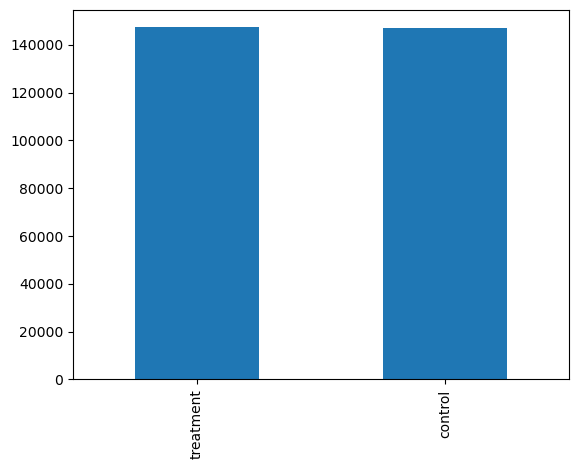

In [59]:
df["group"].value_counts().plot(kind="bar")

In [60]:
df["landing_page"].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

<Axes: >

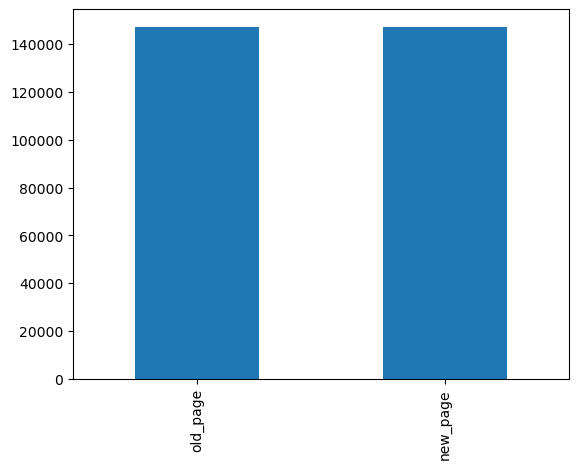

In [61]:
df["landing_page"].value_counts().plot(kind="bar")

<Axes: >

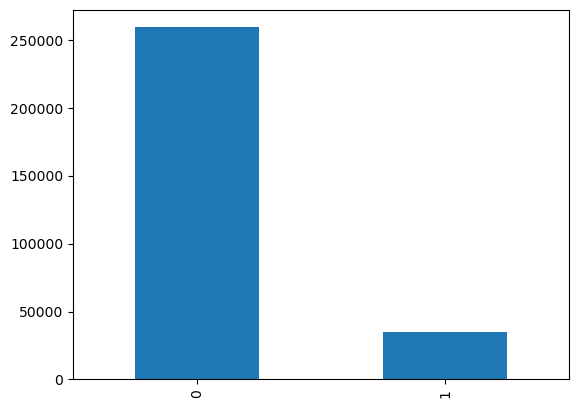

In [62]:
df["converted"].value_counts().plot(kind="bar")

# PREPROCSSING

Converting Timestamp column into datetime datatype

In [63]:
def convert(date):
    date_converted = datetime.datetime.strptime(date , '%Y-%m-%d %H:%M:%S.%f')
    return date_converted
    
df['timestamp'] = df["timestamp"].apply(convert)

In [64]:
type(df["timestamp"][1])

pandas._libs.tslibs.timestamps.Timestamp

Removing invalid users who are in multiple buckets ie test and control

In [66]:
df=df.drop_duplicates(subset=['user_id'])
print(df.shape)

(290584, 5)


Adding a "week" column to track the timeline of the experiment

In [68]:
df['week'] = df['timestamp'].apply(lambda x: x.isocalendar()[1])
df.sample()

,user_id,timestamp,group,landing_page,converted,week
202996,897300,2017-01-13 17:20:47.520477,control,old_page,0,2


# A/B TESTING USING FREQUENTIST APPROACH

In [69]:
# LETS DERIVE OUR KPI WHICH IS CONVERSION RATES FOR CONTROL AND TEST GROUPS AND ALSO FIND THE LIFT

NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time

experiment_data = df[df['week'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round(treatment_conversion_perc - control_conversion_perc, 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.884%
Control Conversion Rate: 12.03%
Lift = -0.146%


Thus the test group (users which had exposure to the new website) have a lower conversion rate.
We get a lift of -0.1, which states that the new website had a slighly negative effect.
However we must test for statistical significance

# STATISTICAL TESTING 

We use chiquare test of independence to check for association since the variables are categorical

Null hypothesis: The variables have a statistically significant association

Alternate hypothesis: The variables do not have a statistically significant association

In [70]:
# CONDUCTING CHI SQUARE TEST OF INDEPENDENCE TO CHECK FOR SIGNIFICANT ASSOCIATION BETWEEN CONVERSION (1 or 0) AND WEBSITE TYPE (OLD OR NEW)

# Create Contingency Table for Chi Squared Test
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted
contingency_table = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])

In [71]:
contingency_table

array([[ 17471, 127761],
       [ 17274, 128078]], dtype=int64)

In [73]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)
print("p value", p_value)

p value 0.22689933216132585


# INTERPRETATION

Since p value>0.05 , we must reject the null hypothesis and conclude that the variables do not have a statistically significant association

P value can also be interpreted as there is a 22% risk of concluding that an association between the variables exists when there is no actual association.